In [33]:
import numpy as np
import pandas as pd
import datatable as dt
import time
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import seaborn as sns
from IPython.core.display import HTML, SVG
import IPython 
from ipywidgets import Layout
from ipywidgets import widgets
from IPython.display import display
from matplotlib import pyplot as plt
from plotly import graph_objs as go
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn')

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn import pipeline
from sklearn.pipeline import *
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import *
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.base import BaseEstimator, TransformerMixin
from catboost import CatBoostClassifier

# Encoder
import category_encoders
from category_encoders.target_encoder import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.ordinal import OrdinalEncoder


# Home made
from cmougan import *
from featgen_transformers import *

In [55]:
accidents = pd.read_csv('Dataset & booklet/accidents.csv')
vehicles = pd.read_csv('Dataset & booklet/vehicles.csv')
test = pd.read_csv('Dataset & booklet/test.csv')

import pandas_profiling

profile = pandas_profiling.ProfileReport(accidents)
profile.to_file('accidents.html')


profile = pandas_profiling.ProfileReport(vehicles)
profile.to_file('vehicles.html')


profile = pandas_profiling.ProfileReport(test)
profile.to_file('test.html')


# OJO

In [56]:
accidents.shape

(137599, 30)

In [57]:
len(accidents.accident_id.unique())

136575

In [58]:
test.shape

(129950, 29)

In [59]:
len(test.accident_id.unique())

129950

NO SE QUE SIGNIFICA ESTO

# Split

In [60]:
train= accidents.set_index('accident_id').join(vehicles,on='accident_id')


In [61]:
test = test.set_index('accident_id').join(vehicles,on='accident_id')

In [62]:
train['train'] = 1
test['train']  = 0

In [63]:
df = train.append(test)

In [64]:
df.shape

(267549, 52)

In [65]:
train.shape[0]+test.shape[0]

267549

In [66]:
df.head()

,1st_Point_of_Impact,1st_road_class,1st_road_number,2nd_road_class,2nd_road_number,Age_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_(CC),Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,Propulsion_Code,Sex_of_Driver,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_IMD_Decile,Vehicle_Leaving_Carriageway,Vehicle_Location-Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive?,accident_id,carriageway_hazards,date,junction_control,junction_detail,latitude,light_conditions,local_authority_district,local_authority_highway,location_easting_osgr,location_northing_osgr,longitude,lsoa_of_accident_location,number_of_casualties,number_of_vehicles,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,police_force,road_surface_conditions,road_type,special_conditions_at_site,speed_limit,target,time,train,urban_or_rural_area,weather_conditions
accident_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
359433,Front,A,4006,-1,0.0,-1.0,5.0,-1.0,-1.0,1200.0,None,None,Not known,Not at or within 20 metres of junction,Petrol,Not known,None,No tow/articulation,-1.0,Did not leave carriageway,On main c'way - not in restricted lane,Parked,2.0,Car,No,315328.0,None,2016-01-11,-1,Not at junction or within 20 metres,51.584754,Darkness - lights unlit,Brent,Brent,519310.0,188730.0,-0.279323,E01000543,1,2,None within 50 metres,No physical crossing facilities within 50 metres,Metropolitan Police,Dry,4,None,30.0,0.0,02:30,1,Urban,1
446617,Nearside,A,207,Unclassified,0.0,25.0,14.0,1.0,-1.0,599.0,None,None,Not known,Approaching junction or waiting/parked at junc...,Petrol,Male,Overturned,No tow/articulation,-1.0,Offside,On main c'way - not in restricted lane,Overtaking moving vehicle - offside,1.0,Motorcycle over 500cc,No,303956.0,None,2016-01-11,Give way or uncontrolled,Other junction,51.449595,Darkness - lights lit,Bexley,Bexley,551920.0,174560.0,0.184928,E01000375,1,1,None within 50 metres,No physical crossing facilities within 50 metres,Metropolitan Police,Dry,4,None,30.0,0.0,00:37,1,Urban,1
342312,Nearside,A,4020,A,4020.0,23.0,12.0,1.0,1.0,1968.0,None,None,Not known,Mid Junction - on roundabout or on main road,Heavy oil,Male,None,No tow/articulation,1.0,Did not leave carriageway,On main c'way - not in restricted lane,Going ahead other,1.0,Car,No,389085.0,None,2016-01-11,Give way or uncontrolled,Roundabout,51.543563,Darkness - lights lit,Hillingdon,Hillingdon,505930.0,183850.0,-0.473837,E01033725,1,1,None within 50 metres,No physical crossing facilities within 50 metres,Metropolitan Police,Dry,3,None,30.0,0.0,01:25,1,Urban,1
495118,NaN,A,217,A,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2016-01-11,Auto traffic signal,T or staggered junction,51.404958,Daylight,Merton,Merton,527770.0,168930.0,-0.164442,E01003379,1,1,None within 50 metres,No physical crossing facilities within 50 metres,Metropolitan Police,Dry,4,None,30.0,0.0,09:15,1,Urban,1
595500,NaN,A,312,-1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,2016-01-11,-1,Not at junction or within 20 metres,51.483139,Daylight,Hounslow,Hounslow,510740.0,177230.0,-0.406580,E01002583,1,2,None within 50 metres,No physical crossing facilities within 50 metres,Metropolitan Police,Dry,1,None,40.0,0.0,07:53,1,Urban,1


Encoding

In [67]:
cbe = Encodings(encoding_type="CatBoostEncoder")

In [68]:
cbe.fit(train.drop(columns='target'),train.target)

Encodings(columns='All', encoding_type='CatBoostEncoder',
          return_categorical=True)

In [69]:
df = cbe.transform(df)

In [70]:
df = df._get_numeric_data()

In [71]:
df = reduce_mem_usage(df)

Memory usage of dataframe is 109.02 MB
Memory usage after optimization is: 29.05 MB
Decreased by 73.3%


# Adversarial Trainning

In [29]:
from sklearn.utils import shuffle
df = shuffle(df)

In [41]:
X_tr, X_te, y_tr, y_te = sklearn.model_selection.train_test_split(df.drop(columns=['train','target']),df.train,random_state=1)

In [42]:
cb = CatBoostClassifier()

pipe_cb = Pipeline([('cb',cb)])
pipeline_grid = {
    "cb__depth": [None,3]
        }

In [43]:
# Execution Hyperparameters
n_jobs=-1
cv = 3
n_max= 2_000
pipe_cv = GridSearchCV(pipe_cb, param_grid=pipeline_grid, n_jobs = n_jobs, cv=cv,scoring='roc_auc')


In [44]:
pipe_cv, pipe_best_estimator  = fit_cv_subsample(pipe_cv, X_tr, y_tr, n_max = n_max);

Learning rate set to 0.020385
0:	learn: 0.6509680	total: 87.9ms	remaining: 1m 27s
1:	learn: 0.6083456	total: 110ms	remaining: 54.9s
2:	learn: 0.5703120	total: 130ms	remaining: 43.2s
3:	learn: 0.5289206	total: 150ms	remaining: 37.3s
4:	learn: 0.4882870	total: 168ms	remaining: 33.5s
5:	learn: 0.4550016	total: 188ms	remaining: 31.1s
6:	learn: 0.4296711	total: 217ms	remaining: 30.8s
7:	learn: 0.3980307	total: 237ms	remaining: 29.4s
8:	learn: 0.3706188	total: 256ms	remaining: 28.2s
9:	learn: 0.3409753	total: 275ms	remaining: 27.3s
10:	learn: 0.3193544	total: 326ms	remaining: 29.3s
11:	learn: 0.3007116	total: 361ms	remaining: 29.7s
12:	learn: 0.2808315	total: 377ms	remaining: 28.6s
13:	learn: 0.2643261	total: 395ms	remaining: 27.9s
14:	learn: 0.2479650	total: 415ms	remaining: 27.2s
15:	learn: 0.2295234	total: 431ms	remaining: 26.5s
16:	learn: 0.2103082	total: 451ms	remaining: 26.1s
17:	learn: 0.1993465	total: 473ms	remaining: 25.8s
18:	learn: 0.1817328	total: 510ms	remaining: 26.3s
19:	learn

166:	learn: 0.0011651	total: 4.17s	remaining: 20.8s
167:	learn: 0.0011546	total: 4.2s	remaining: 20.8s
168:	learn: 0.0011524	total: 4.22s	remaining: 20.7s
169:	learn: 0.0011477	total: 4.24s	remaining: 20.7s
170:	learn: 0.0011367	total: 4.26s	remaining: 20.7s
171:	learn: 0.0011325	total: 4.29s	remaining: 20.6s
172:	learn: 0.0011211	total: 4.31s	remaining: 20.6s
173:	learn: 0.0011124	total: 4.33s	remaining: 20.6s
174:	learn: 0.0010964	total: 4.36s	remaining: 20.6s
175:	learn: 0.0010931	total: 4.38s	remaining: 20.5s
176:	learn: 0.0010894	total: 4.41s	remaining: 20.5s
177:	learn: 0.0010695	total: 4.44s	remaining: 20.5s
178:	learn: 0.0010536	total: 4.46s	remaining: 20.5s
179:	learn: 0.0010521	total: 4.48s	remaining: 20.4s
180:	learn: 0.0010508	total: 4.5s	remaining: 20.4s
181:	learn: 0.0010370	total: 4.52s	remaining: 20.3s
182:	learn: 0.0010327	total: 4.54s	remaining: 20.3s
183:	learn: 0.0010276	total: 4.57s	remaining: 20.3s
184:	learn: 0.0010107	total: 4.59s	remaining: 20.2s
185:	learn: 0.

328:	learn: 0.0004750	total: 7.86s	remaining: 16s
329:	learn: 0.0004744	total: 7.88s	remaining: 16s
330:	learn: 0.0004725	total: 7.91s	remaining: 16s
331:	learn: 0.0004704	total: 7.94s	remaining: 16s
332:	learn: 0.0004696	total: 7.96s	remaining: 15.9s
333:	learn: 0.0004689	total: 7.97s	remaining: 15.9s
334:	learn: 0.0004678	total: 7.99s	remaining: 15.9s
335:	learn: 0.0004670	total: 8.01s	remaining: 15.8s
336:	learn: 0.0004634	total: 8.03s	remaining: 15.8s
337:	learn: 0.0004628	total: 8.05s	remaining: 15.8s
338:	learn: 0.0004621	total: 8.07s	remaining: 15.7s
339:	learn: 0.0004616	total: 8.1s	remaining: 15.7s
340:	learn: 0.0004609	total: 8.13s	remaining: 15.7s
341:	learn: 0.0004594	total: 8.15s	remaining: 15.7s
342:	learn: 0.0004585	total: 8.17s	remaining: 15.6s
343:	learn: 0.0004571	total: 8.19s	remaining: 15.6s
344:	learn: 0.0004566	total: 8.21s	remaining: 15.6s
345:	learn: 0.0004558	total: 8.23s	remaining: 15.6s
346:	learn: 0.0004551	total: 8.26s	remaining: 15.5s
347:	learn: 0.0004548

494:	learn: 0.0003150	total: 11.7s	remaining: 12s
495:	learn: 0.0003148	total: 11.8s	remaining: 12s
496:	learn: 0.0003145	total: 11.8s	remaining: 11.9s
497:	learn: 0.0003132	total: 11.8s	remaining: 11.9s
498:	learn: 0.0003120	total: 11.8s	remaining: 11.9s
499:	learn: 0.0003117	total: 11.9s	remaining: 11.9s
500:	learn: 0.0003115	total: 11.9s	remaining: 11.8s
501:	learn: 0.0003113	total: 11.9s	remaining: 11.8s
502:	learn: 0.0003095	total: 11.9s	remaining: 11.8s
503:	learn: 0.0003078	total: 12s	remaining: 11.8s
504:	learn: 0.0003075	total: 12s	remaining: 11.7s
505:	learn: 0.0003073	total: 12s	remaining: 11.7s
506:	learn: 0.0003062	total: 12s	remaining: 11.7s
507:	learn: 0.0003060	total: 12.1s	remaining: 11.7s
508:	learn: 0.0003057	total: 12.1s	remaining: 11.7s
509:	learn: 0.0003037	total: 12.1s	remaining: 11.6s
510:	learn: 0.0003035	total: 12.1s	remaining: 11.6s
511:	learn: 0.0003033	total: 12.2s	remaining: 11.6s
512:	learn: 0.0003031	total: 12.2s	remaining: 11.6s
513:	learn: 0.0003014	to

660:	learn: 0.0002393	total: 15.6s	remaining: 8.01s
661:	learn: 0.0002391	total: 15.6s	remaining: 7.99s
662:	learn: 0.0002390	total: 15.7s	remaining: 7.96s
663:	learn: 0.0002389	total: 15.7s	remaining: 7.94s
664:	learn: 0.0002388	total: 15.7s	remaining: 7.92s
665:	learn: 0.0002387	total: 15.7s	remaining: 7.89s
666:	learn: 0.0002386	total: 15.7s	remaining: 7.86s
667:	learn: 0.0002384	total: 15.8s	remaining: 7.84s
668:	learn: 0.0002383	total: 15.8s	remaining: 7.81s
669:	learn: 0.0002382	total: 15.8s	remaining: 7.79s
670:	learn: 0.0002376	total: 15.8s	remaining: 7.76s
671:	learn: 0.0002375	total: 15.8s	remaining: 7.74s
672:	learn: 0.0002373	total: 15.9s	remaining: 7.71s
673:	learn: 0.0002372	total: 15.9s	remaining: 7.69s
674:	learn: 0.0002371	total: 15.9s	remaining: 7.66s
675:	learn: 0.0002370	total: 15.9s	remaining: 7.63s
676:	learn: 0.0002361	total: 16s	remaining: 7.61s
677:	learn: 0.0002360	total: 16s	remaining: 7.58s
678:	learn: 0.0002359	total: 16s	remaining: 7.56s
679:	learn: 0.0002

823:	learn: 0.0002055	total: 19s	remaining: 4.06s
824:	learn: 0.0002048	total: 19.1s	remaining: 4.05s
825:	learn: 0.0002048	total: 19.1s	remaining: 4.02s
826:	learn: 0.0002046	total: 19.1s	remaining: 4s
827:	learn: 0.0002046	total: 19.1s	remaining: 3.98s
828:	learn: 0.0002045	total: 19.2s	remaining: 3.95s
829:	learn: 0.0002044	total: 19.2s	remaining: 3.93s
830:	learn: 0.0002038	total: 19.2s	remaining: 3.91s
831:	learn: 0.0002038	total: 19.2s	remaining: 3.89s
832:	learn: 0.0002037	total: 19.3s	remaining: 3.86s
833:	learn: 0.0002036	total: 19.3s	remaining: 3.84s
834:	learn: 0.0002036	total: 19.3s	remaining: 3.81s
835:	learn: 0.0002035	total: 19.3s	remaining: 3.79s
836:	learn: 0.0002034	total: 19.3s	remaining: 3.76s
837:	learn: 0.0002034	total: 19.3s	remaining: 3.74s
838:	learn: 0.0002033	total: 19.4s	remaining: 3.72s
839:	learn: 0.0002033	total: 19.4s	remaining: 3.69s
840:	learn: 0.0002032	total: 19.4s	remaining: 3.67s
841:	learn: 0.0002031	total: 19.4s	remaining: 3.64s
842:	learn: 0.000

985:	learn: 0.0001787	total: 22.5s	remaining: 319ms
986:	learn: 0.0001787	total: 22.5s	remaining: 296ms
987:	learn: 0.0001786	total: 22.5s	remaining: 274ms
988:	learn: 0.0001785	total: 22.6s	remaining: 251ms
989:	learn: 0.0001781	total: 22.6s	remaining: 228ms
990:	learn: 0.0001780	total: 22.6s	remaining: 205ms
991:	learn: 0.0001774	total: 22.6s	remaining: 183ms
992:	learn: 0.0001773	total: 22.6s	remaining: 160ms
993:	learn: 0.0001772	total: 22.7s	remaining: 137ms
994:	learn: 0.0001771	total: 22.7s	remaining: 114ms
995:	learn: 0.0001771	total: 22.7s	remaining: 91.2ms
996:	learn: 0.0001770	total: 22.7s	remaining: 68.4ms
997:	learn: 0.0001770	total: 22.8s	remaining: 45.6ms
998:	learn: 0.0001769	total: 22.8s	remaining: 22.8ms
999:	learn: 0.0001769	total: 22.8s	remaining: 0us


In [45]:
pd.DataFrame(pipe_cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cb__depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,132.429702,1.209582,0.015490,0.001209,None,{'cb__depth': None},1.0,1.0,0.999034,0.999678,0.000455,1
1,72.365470,32.448310,0.014408,0.004608,3,{'cb__depth': 3},1.0,1.0,0.998609,0.999537,0.000656,2


In [46]:
pipe_best_estimator.fit(X_tr,y_tr);

Learning rate set to 0.075277
0:	learn: 0.3968209	total: 85.3ms	remaining: 1m 25s
1:	learn: 0.2569686	total: 193ms	remaining: 1m 36s
2:	learn: 0.1433061	total: 298ms	remaining: 1m 38s
3:	learn: 0.0788437	total: 362ms	remaining: 1m 30s
4:	learn: 0.0458892	total: 455ms	remaining: 1m 30s
5:	learn: 0.0276779	total: 530ms	remaining: 1m 27s
6:	learn: 0.0164819	total: 595ms	remaining: 1m 24s
7:	learn: 0.0101144	total: 677ms	remaining: 1m 23s
8:	learn: 0.0066758	total: 753ms	remaining: 1m 22s
9:	learn: 0.0044892	total: 817ms	remaining: 1m 20s
10:	learn: 0.0031269	total: 879ms	remaining: 1m 19s
11:	learn: 0.0021480	total: 958ms	remaining: 1m 18s
12:	learn: 0.0015128	total: 1.01s	remaining: 1m 17s
13:	learn: 0.0011384	total: 1.07s	remaining: 1m 15s
14:	learn: 0.0008476	total: 1.16s	remaining: 1m 15s
15:	learn: 0.0006615	total: 1.22s	remaining: 1m 14s
16:	learn: 0.0005118	total: 1.28s	remaining: 1m 13s
17:	learn: 0.0004172	total: 1.33s	remaining: 1m 12s
18:	learn: 0.0003340	total: 1.41s	remaining

160:	learn: 0.0000048	total: 10.4s	remaining: 54.2s
161:	learn: 0.0000047	total: 10.5s	remaining: 54.1s
162:	learn: 0.0000047	total: 10.5s	remaining: 54.1s
163:	learn: 0.0000047	total: 10.6s	remaining: 54.1s
164:	learn: 0.0000047	total: 10.7s	remaining: 54.1s
165:	learn: 0.0000046	total: 10.8s	remaining: 54.1s
166:	learn: 0.0000046	total: 10.8s	remaining: 54s
167:	learn: 0.0000046	total: 10.9s	remaining: 54s
168:	learn: 0.0000045	total: 11s	remaining: 54s
169:	learn: 0.0000045	total: 11s	remaining: 53.9s
170:	learn: 0.0000045	total: 11.1s	remaining: 53.9s
171:	learn: 0.0000044	total: 11.2s	remaining: 53.9s
172:	learn: 0.0000044	total: 11.3s	remaining: 53.9s
173:	learn: 0.0000044	total: 11.3s	remaining: 53.9s
174:	learn: 0.0000043	total: 11.4s	remaining: 53.8s
175:	learn: 0.0000043	total: 11.5s	remaining: 53.7s
176:	learn: 0.0000043	total: 11.5s	remaining: 53.6s
177:	learn: 0.0000043	total: 11.6s	remaining: 53.5s
178:	learn: 0.0000042	total: 11.6s	remaining: 53.4s
179:	learn: 0.0000042	

320:	learn: 0.0000026	total: 21.7s	remaining: 45.9s
321:	learn: 0.0000026	total: 21.8s	remaining: 45.8s
322:	learn: 0.0000026	total: 21.8s	remaining: 45.7s
323:	learn: 0.0000026	total: 21.9s	remaining: 45.6s
324:	learn: 0.0000026	total: 21.9s	remaining: 45.5s
325:	learn: 0.0000026	total: 22s	remaining: 45.4s
326:	learn: 0.0000026	total: 22s	remaining: 45.3s
327:	learn: 0.0000026	total: 22.1s	remaining: 45.2s
328:	learn: 0.0000026	total: 22.1s	remaining: 45.1s
329:	learn: 0.0000026	total: 22.2s	remaining: 45.1s
330:	learn: 0.0000025	total: 22.3s	remaining: 45s
331:	learn: 0.0000025	total: 22.4s	remaining: 45s
332:	learn: 0.0000025	total: 22.4s	remaining: 44.9s
333:	learn: 0.0000025	total: 22.5s	remaining: 44.9s
334:	learn: 0.0000025	total: 22.6s	remaining: 44.8s
335:	learn: 0.0000025	total: 22.6s	remaining: 44.7s
336:	learn: 0.0000025	total: 22.7s	remaining: 44.6s
337:	learn: 0.0000025	total: 22.7s	remaining: 44.5s
338:	learn: 0.0000025	total: 22.8s	remaining: 44.4s
339:	learn: 0.000002

479:	learn: 0.0000020	total: 32.1s	remaining: 34.8s
480:	learn: 0.0000020	total: 32.1s	remaining: 34.7s
481:	learn: 0.0000020	total: 32.2s	remaining: 34.6s
482:	learn: 0.0000020	total: 32.2s	remaining: 34.5s
483:	learn: 0.0000020	total: 32.3s	remaining: 34.4s
484:	learn: 0.0000020	total: 32.4s	remaining: 34.4s
485:	learn: 0.0000020	total: 32.4s	remaining: 34.3s
486:	learn: 0.0000020	total: 32.5s	remaining: 34.2s
487:	learn: 0.0000020	total: 32.5s	remaining: 34.1s
488:	learn: 0.0000020	total: 32.6s	remaining: 34s
489:	learn: 0.0000020	total: 32.6s	remaining: 34s
490:	learn: 0.0000020	total: 32.7s	remaining: 33.9s
491:	learn: 0.0000020	total: 32.8s	remaining: 33.9s
492:	learn: 0.0000020	total: 32.9s	remaining: 33.8s
493:	learn: 0.0000020	total: 32.9s	remaining: 33.7s
494:	learn: 0.0000020	total: 33s	remaining: 33.7s
495:	learn: 0.0000020	total: 33.1s	remaining: 33.6s
496:	learn: 0.0000020	total: 33.2s	remaining: 33.6s
497:	learn: 0.0000020	total: 33.2s	remaining: 33.5s
498:	learn: 0.0000

641:	learn: 0.0000018	total: 41s	remaining: 22.9s
642:	learn: 0.0000018	total: 41.1s	remaining: 22.8s
643:	learn: 0.0000018	total: 41.1s	remaining: 22.7s
644:	learn: 0.0000018	total: 41.2s	remaining: 22.7s
645:	learn: 0.0000018	total: 41.2s	remaining: 22.6s
646:	learn: 0.0000017	total: 41.3s	remaining: 22.5s
647:	learn: 0.0000017	total: 41.4s	remaining: 22.5s
648:	learn: 0.0000017	total: 41.4s	remaining: 22.4s
649:	learn: 0.0000017	total: 41.5s	remaining: 22.3s
650:	learn: 0.0000017	total: 41.5s	remaining: 22.3s
651:	learn: 0.0000017	total: 41.6s	remaining: 22.2s
652:	learn: 0.0000017	total: 41.6s	remaining: 22.1s
653:	learn: 0.0000017	total: 41.7s	remaining: 22s
654:	learn: 0.0000017	total: 41.7s	remaining: 22s
655:	learn: 0.0000017	total: 41.8s	remaining: 21.9s
656:	learn: 0.0000017	total: 41.8s	remaining: 21.8s
657:	learn: 0.0000017	total: 41.9s	remaining: 21.8s
658:	learn: 0.0000017	total: 41.9s	remaining: 21.7s
659:	learn: 0.0000017	total: 42s	remaining: 21.6s
660:	learn: 0.000001

802:	learn: 0.0000016	total: 50.5s	remaining: 12.4s
803:	learn: 0.0000016	total: 50.5s	remaining: 12.3s
804:	learn: 0.0000016	total: 50.6s	remaining: 12.3s
805:	learn: 0.0000016	total: 50.6s	remaining: 12.2s
806:	learn: 0.0000016	total: 50.7s	remaining: 12.1s
807:	learn: 0.0000016	total: 50.7s	remaining: 12.1s
808:	learn: 0.0000016	total: 50.8s	remaining: 12s
809:	learn: 0.0000016	total: 50.8s	remaining: 11.9s
810:	learn: 0.0000016	total: 50.9s	remaining: 11.9s
811:	learn: 0.0000016	total: 51s	remaining: 11.8s
812:	learn: 0.0000016	total: 51s	remaining: 11.7s
813:	learn: 0.0000016	total: 51.1s	remaining: 11.7s
814:	learn: 0.0000016	total: 51.1s	remaining: 11.6s
815:	learn: 0.0000016	total: 51.2s	remaining: 11.5s
816:	learn: 0.0000016	total: 51.2s	remaining: 11.5s
817:	learn: 0.0000016	total: 51.3s	remaining: 11.4s
818:	learn: 0.0000016	total: 51.3s	remaining: 11.3s
819:	learn: 0.0000016	total: 51.4s	remaining: 11.3s
820:	learn: 0.0000016	total: 51.4s	remaining: 11.2s
821:	learn: 0.0000

962:	learn: 0.0000016	total: 59.2s	remaining: 2.27s
963:	learn: 0.0000016	total: 59.3s	remaining: 2.21s
964:	learn: 0.0000016	total: 59.3s	remaining: 2.15s
965:	learn: 0.0000016	total: 59.4s	remaining: 2.09s
966:	learn: 0.0000016	total: 59.4s	remaining: 2.03s
967:	learn: 0.0000016	total: 59.5s	remaining: 1.97s
968:	learn: 0.0000016	total: 59.6s	remaining: 1.91s
969:	learn: 0.0000016	total: 59.6s	remaining: 1.84s
970:	learn: 0.0000016	total: 59.7s	remaining: 1.78s
971:	learn: 0.0000016	total: 59.7s	remaining: 1.72s
972:	learn: 0.0000016	total: 59.8s	remaining: 1.66s
973:	learn: 0.0000016	total: 59.9s	remaining: 1.6s
974:	learn: 0.0000016	total: 59.9s	remaining: 1.54s
975:	learn: 0.0000016	total: 60s	remaining: 1.48s
976:	learn: 0.0000016	total: 1m	remaining: 1.41s
977:	learn: 0.0000016	total: 1m	remaining: 1.35s
978:	learn: 0.0000016	total: 1m	remaining: 1.29s
979:	learn: 0.0000016	total: 1m	remaining: 1.23s
980:	learn: 0.0000016	total: 1m	remaining: 1.17s
981:	learn: 0.0000016	total: 1

In [47]:
auc_score(y_te,pipe_best_estimator.predict_proba(X_te))


1.0

In [48]:
print('The score of the gradient boosting algorithm in train is',
      np.round(auc_score(y_tr,pipe_best_estimator.predict_proba(X_tr)),decimals=2))

print('The score of the gradient boosting algorithm in test is',
      np.round(auc_score(y_te,pipe_best_estimator.predict_proba(X_te)),decimals=2))

The score of the gradient boosting algorithm in train is 1.0
The score of the gradient boosting algorithm in test is 1.0


40 features, reduction of 20.00%


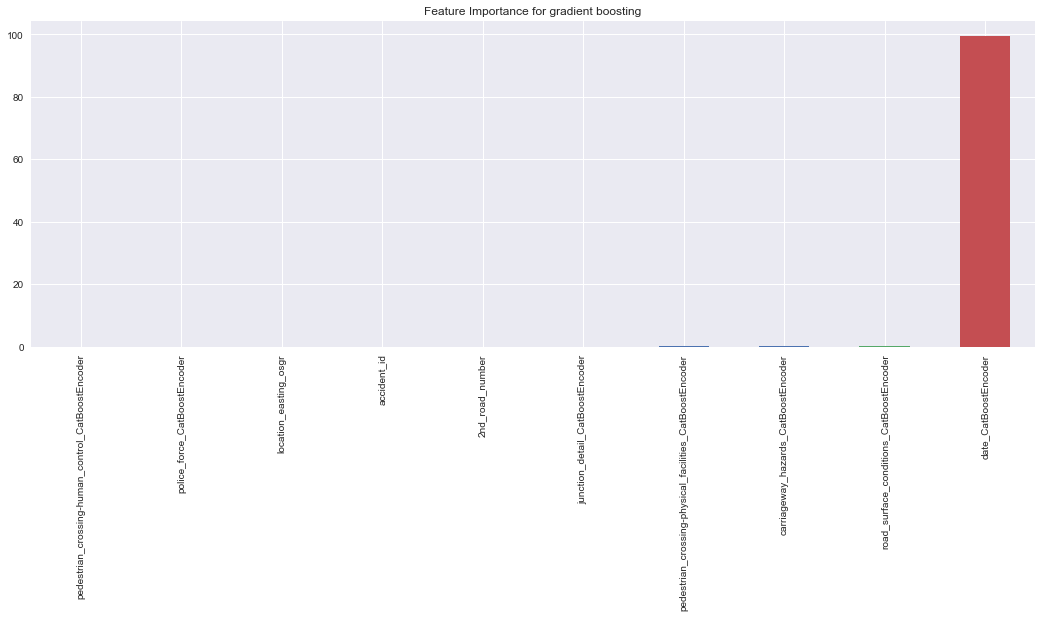

In [49]:
feature_importance = pd.Series(index = X_tr.columns, data = np.abs(pipe_best_estimator.named_steps['cb'].get_feature_importance()))
n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(n_selected_features,(1-n_selected_features/len(feature_importance))*100))
plt.figure()
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))
plt.title('Feature Importance for gradient boosting')
plt.show()

# Feature Differences between train and test

In [72]:
train = df[df['train']==1]
test = df[df['train']==0]
train = train.drop(columns='train')
test = test.drop(columns=['train','target'])

**Kolmogorov-Smirnov** statistic

(K–S test or KS test) is a nonparametric test of the equality of continuous one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test).

The idea is to compute the Kolmogorov-Smirnov statistic on 2 samples to test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.  This will allow us to see if there are major changes between a variable in the train and in the test dataset. 

The *KS* statistic test computes the KS statistic and pvalue. If the p value is less than .1 the null hypothesis is rejected. In this case you are sampling values from corresponding columns in test and train data frame and storing their pvalues in the list *Se*. If the p value is less than .1 the null hypothesis is rejected. Columns with pvalues less than 0.1 are added to the list_discarded.

In [73]:
# This tests whether 2 samples are drawn from the same distribution. The distribution is assumed to be continuous.
from scipy.stats import ks_2samp 
from tqdm import tqdm

list_p_value =[]

for i in tqdm(test.columns):
    list_p_value.append(ks_2samp(test[i] ,  train[i])[1])

Se = pd.Series(list_p_value, index = test.columns).sort_values() 
list_discarded = list(Se[Se < .4].index)

100%|██████████| 50/50 [00:02<00:00, 17.37it/s]


In [74]:
pd.DataFrame(Se).rename(columns={0:'p-value'})

,p-value
date_CatBoostEncoder,0.000000e+00
lsoa_of_accident_location_CatBoostEncoder,2.139876e-124
1st_road_number,6.389100e-118
1st_road_class_CatBoostEncoder,1.198683e-49
urban_or_rural_area_CatBoostEncoder,1.098965e-36
speed_limit,9.283725e-36
police_force_CatBoostEncoder,1.828831e-35
longitude,2.976148e-35
local_authority_highway_CatBoostEncoder,1.744037e-28
local_authority_district_CatBoostEncoder,2.767778e-26
